# The Cartography of Conformational Space: Choosing the Right Map

### Introduction

In the study of complex molecular systems, the "curse of dimensionality" is a constant challenge. Molecular Dynamics (MD) simulations generate massive high-dimensional datasets (coordinates of thousands of atoms over time), but the physical mechanisms we wish to understand—folding, binding, or isomerization—typically are better understoof in a low-dimensional manifold.

To bridge this gap, we use **Collective Variables (CVs)**: functions that compress the high-dimensional configuration space into a few meaningful descriptors. However, "meaningful" is subjective. Depending on the mathematical objective we choose to optimize, the resulting CV can describe the system in radically different ways. Much like choosing what kind of map used for navigation (topographic, political, road map), the choice of CV design philosophy shapes our understanding of the underlying molecular landscape. Every map projection distorts the molecular landscape to optimize specific mathematical goals.

In this notebook, we will use the most boring toy system, **Alanine Dipeptide**, to explore and visualize the three dominant philosophies in data-driven CV design.

### The Three Philosophies

We will train three different models on the **same trajectory**:

1. **Geometric (Maximizing Variance)**
* **The Logic:** "The most important features are the ones where the atoms move the most."
* **The Method:** Principal Component Analysis (PCA) or Autoencoders.
* **The Goal:** Reconstruction of structure.


2. **Kinetic (Maximizing Slowness)**
* **The Logic:** "The most important features are the ones that take the longest time to change."
* **The Method:** Time-lagged Independent Component Analysis (TICA) or SRVs.
* **The Goal:** Identification of rare events and transition pathways.


3. **Discriminative (Maximizing Separability)**
* **The Logic:** "The most important features are the ones that distinguish State A from State B."
* **The Method:** Linear Discriminant Analysis (LDA) or Deep-LDA.
* **The Goal:** Classification of known metastable states.



### Learning Objectives

By the end of this notebook, you will be able to:

* Visualize how **variance-based models** can sometimes obscure rare transition events.
* Observe how **kinetic models** can identify reaction coordinates that are geometrically subtle but dynamically slow.
* Understand the "shortcut" behavior of **discriminative models**, which separate states perfectly but may ignore the transition mechanism between them.

## Alanine Dipeptide

We will utilize a standard simulation of **Alanine Dipeptide in vacuum**.

10 ns trajectories at 300, 400 and 500 K are available as input. The value of all coordinates and the $\phi$ and $\psi$ angles (see image below) were saved every 1 ps. Thus we have $10^4$ frames for each trajectory.

The typical free energy surface of alanine dipeptide is shown below.

<center><img src="../../../deep_cartograph/data/alanine_dipeptide/aldip.png" width="800"/></center>

In this system there are 3 main minima: C7eq, C5 and C7ax. The minima C7eq and C5 are separated by a low free energy barrier, while the minimum C7ax is separated from the other two by a high free energy barrier. Thus, the system spends more time transitioning between C5 and C7eq, while transitions to/from C7ax are much rarer. The minima C7eq and C5 will be more populated while C7ax will be less populated.

- Transitions between C5 and C7eq (fast transition, more frequent)
- Transition between C7eq or C5 and C7ax (slow transition, less frequent)

In [1]:
# Import libraries and define functions
from deep_cartograph.modules.plumed.colvars import read_colvars
from deep_cartograph.modules.cv_learning import CVCalculator
from deep_cartograph.modules.statistics import cluster_data
from deep_cartograph.deep_carto import deep_cartograph

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.data import DictDataset, DictModule
import importlib.resources as resources
from mlcolvar.core.stats import LDA
from mlcolvar.cvs import DeepLDA
from deep_cartograph import data
import matplotlib.pyplot as plt
from typing import Literal
from pathlib import Path
import pandas as pd
import numpy as np
import lightning
import shutil
import torch
import yaml
import math
import os

# Get the path to the data
data_folder = resources.files(data)

def plot_scatter(x, y, color, xlabel, ylabel, xlims = None, ylims = None, title = None, colorlabel = None, font_size=12):
    """
    Generic scatter plot function
    
    Parameters
    ----------
    
    x : np.array
        x data
    y : np.array
        y data
    color : np.array
        color data
    xlabel : str
        x label
    ylabel : str
        y label
    xlims : tuple
        x limits
    ylims : tuple
        y limits
    title : str
        plot title
    colorlabel : str, optional
        color label
    font_size : int, optional
        font size
    """
    
    plt.figure(figsize=(6, 6))
    
    plt.scatter(x, y, c=color, s=1, alpha=0.5, cmap='viridis')
    
    if colorlabel:
        plt.colorbar(label=colorlabel)

    if xlims is not None:
        plt.xlim(xlims)
    if ylims is not None:
        plt.ylim(ylims)

    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

    plt.xlabel(xlabel, fontsize=font_size)
    plt.ylabel(ylabel, fontsize=font_size)
    
    if title is not None:
        plt.title(title, fontsize=font_size)

    plt.show()

def plot_timeseries(time_array, feature1_array, feature2_array, feature1_legend, feature2_legend, features_label, max_time, feature_limits=None, title=None, font_size=12):
    """
    Plot the time series of two features
    
    Parameters
    ----------
    
    time_array : np.array
        time data in ps
    feature1_array : np.array
        feature 1 data
    feature2_array : np.array
        feature 2 data
    feature1_legend : str
        feature 1 label
    feature2_legend : str
        feature 2 label
    features_label : str
        features label for y axis
    max_time : float
        maximum time to plot
    feature_limits : tuple
        feature limits for y axis
    title : str
        plot title
    font_size : int, optional
        font size
    """
    plt.figure(figsize=(10, 5))
    plt.plot(time_array, feature1_array, label=feature1_legend, linestyle='--', marker='x', linewidth=1)
    plt.plot(time_array, feature2_array, label=feature2_legend, linestyle='--', marker='x', linewidth=1)
    plt.xlim(0, max_time)
    if feature_limits is not None:
        plt.ylim(feature_limits)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.xlabel('Time (ps)', fontsize=font_size)
    plt.ylabel(features_label, fontsize=font_size)
    plt.legend(fontsize=font_size)
    if title is not None:
        plt.title(title, fontsize=font_size)
    plt.show()

def plot_model_results(model_path: str, 
    projected_training_path: str,
    x_training_data: np.array,
    y_training_data: np.array,
    features_grid_df: pd.DataFrame, 
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    x_label: str,
    y_label: str, 
    x_lims: tuple,
    y_lims: tuple,
    num_bins: int,
    num_levels: int = 20,
    training_colors: np.array = None,
    cmap = 'bwr'
    ):
    """
    Plot the results for models implemented in Deep Cartograph
    
        1. Load the model and project the features grid data onto the CV space
        2. Read the projection of the training data onto the CV space
        3. Print max and min values of the CV
        4. Contour of the CV landscape with the training data
        5. Filled contour of the CV landscape
        6. Training data colored by CV values
    
    Parameters:
    
        model_path (str): The path to the trained model
        projected_training_path (str): Path to the projected training on the CV space 
        x_training_data (np.array): Array with the x values of the training data
        y_training_data (np.array): Array with the y values of the training data
        features_grid_df (pd.DataFrame): DataFrame with the feature grid to be projected onto the CV space 
        x_grid (np.ndarray): 2D array of x values for contour plots
        y_grid (np.ndarray): 2D array of y values for contour plots
        x_label (str): Label for the x-axis
        y_label (str): Label for the y-axis
        x_lims (tuple): Limits for the x-axis
        y_lims (tuple): Limits for the y-axis
        num_bins (int): Number of bins used to create the grid
        num_levels (int): Number of contour levels to plot
        training_colors (np.array): Array with the colors for the training data points
        cmap (str): Colormap for the training data points
    """
    
    # Load the model and project the grid data onto the CV space
    parent_folder = Path(model_path).parent
    cv_calculator = CVCalculator.load(model_path, output_path=f"{parent_folder.name}_model")
    cv_data = cv_calculator.project_data(features_grid_df)
    
    # Read the projection of the training data onto the CV space
    projected_training_data = pd.read_csv(projected_training_path)
    
    # 1: Contour of the CV landscape with the training data
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.contour(x_grid, 
                y_grid, 
                cv_data[cv_data.columns[0]].values.reshape(num_bins, num_bins), 
                levels=num_levels,
                zorder=1, 
                norm='linear',
                colors='black')
    plt.scatter(x = x_training_data, 
                y = y_training_data, 
                c = training_colors,
                s=5, 
                alpha=1,  
                zorder=0,
                cmap=cmap)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{cv_calculator.cv_name.upper()} CV + training data')
    
    # Color map for CV
    cv_cmap = 'viridis'
    
    # 2: Filled contour of the CV landscape
    plt.subplot(1, 3, 2)
    plt.contourf(x_grid, 
                 y_grid, 
                 cv_data[cv_data.columns[0]].values.reshape(num_bins, num_bins), 
                 levels=num_levels, 
                 cmap=cv_cmap)
    plt.colorbar(label='CV (grid normalization)')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{cv_calculator.cv_name.upper()} CV')
    
    # 3: Training data colored by CV values
    plt.subplot(1, 3, 3)
    plt.scatter(x = x_training_data, 
                y = y_training_data,  
                c = projected_training_data[projected_training_data.columns[0]], 
                s=5, 
                alpha=1, 
                cmap=cv_cmap)
    plt.colorbar(label='CV (training normalization)')
    plt.xlim(x_lims)
    plt.ylim(y_lims)        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'Training Data colored by {cv_calculator.cv_name.upper()} CV')
    plt.show()
    
    return    

# Plots for Discriminant models
def plot_lda_results(
    x_training_data: np.array,
    y_training_data: np.array,
    projected_training_data: pd.DataFrame,
    lda_cv_grid_normalized: pd.DataFrame,
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    x_label: str,
    y_label: str,
    x_lims: tuple,
    y_lims: tuple,
    num_bins: int,
    num_levels: int = 20,
    training_colors: np.array = None,
    cv_cmap = 'viridis',
    model_name: str = 'LDA'):
    """
    Plot the results for LDA and Deep LDA models implemented in Deep Cartograph
    
        1. Contour of the CV landscape with the training data
        2. Filled contour of the CV landscape
        3. Training data colored by CV values
    """
    
    # 1: Contour of the CV landscape with the training data
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.contour(x_grid, 
                y_grid, 
                lda_cv_grid_normalized.values.reshape(num_bins, num_bins), 
                levels=num_levels,
                zorder=1, 
                norm='linear',
                colors='black')
    plt.scatter(x = x_training_data, 
                y = y_training_data, 
                c = training_colors,
                s=5, 
                alpha=1,  
                zorder=0)
    plt.colorbar(label='State labels')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{model_name} CV + training data')

    # 2: Filled contour of the CV landscape
    plt.subplot(1, 3, 2)
    plt.contourf(x_grid, 
                 y_grid, 
                 lda_cv_grid_normalized.values.reshape(num_bins, num_bins), 
                 levels=num_levels, 
                 cmap=cv_cmap)
    plt.colorbar(label='CV (grid normalization)')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{model_name} CV')

    # 3: Training data colored by CV values
    plt.subplot(1, 3, 3)
    plt.scatter(x = x_training_data, 
                y = y_training_data, 
                c = projected_training_data.values,
                s=5, 
                alpha=1, 
                cmap=cv_cmap)
    plt.colorbar(label='CV (training normalization)')
    plt.xlim(x_lims)
    plt.ylim(y_lims)         
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'Projected Training Data onto {model_name} Model')
    plt.show()

/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


## Geometric and kinetic CVs

We can use Deep-Cartograph to compute geometric and kinetic CVs for alanine dipeptide. The geometric CV will be: PCA and a variational autoencoder (VAE), while the kinetic CV will be: TICA and Deep TICA. All models will use the same input features: the phi and psi dihedral angles of the molecule. A configuration file for this purpose is provided in `config_phi_psi.yml` of this same folder.

Note that the phi and psi angles are defined by the following 4 atoms (@atomName_ResidueNumber):

$\phi$: @C_1-@N_2-@CA_2-@C_2

$\psi$: @N_2-@CA_2-@C_2-@N_3

And as we are using periodic features, the angles will be encoded as sine and cosine values through the ALPHABETA PLUMED action. Thus the final set of features will be: 

$\frac{1}{2}(1-\sin(\phi))$

$\frac{1}{2}(1+\cos(\phi))$

$\frac{1}{2}(1-\sin(\psi))$

$\frac{1}{2}(1+\cos(\psi))$

In [2]:
# Temperature of the aladip simulations
temperature : Literal[300, 400, 500] = 500

# Paths to trajectory and topology files
traj_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/trajectory.xtc"
top_path = f"{data_folder}/alanine_dipeptide/input/topology.pdb"

# Load configuration file
config_path = 'config_phi_psi.yml'
with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)

# Output folder
output_folder = f"output_phi_psi_{temperature}K"

# Run workflow
#if os.path.exists(output_folder):
#    shutil.rmtree(output_folder) 
#deep_cartograph(
#    trajectory_data = traj_path,
#    topology_data = top_path,
#    configuration = configuration,
#    output_folder = output_folder
#)

Now we can visualize the training data used

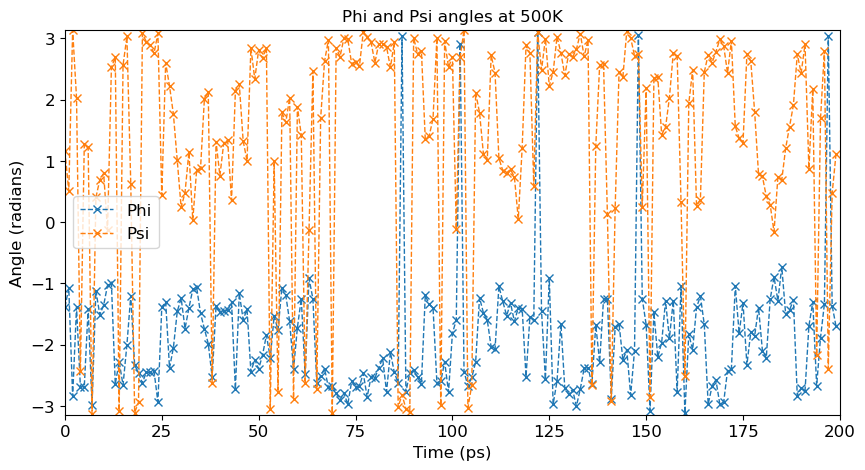

/tmp/ipykernel_104448/152511438.py:60: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=color, s=1, alpha=0.5, cmap='viridis')


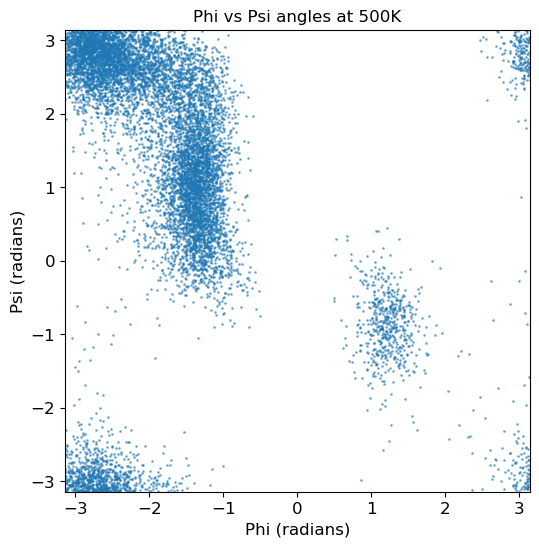

In [3]:
# Time and font to plot
max_time = 200
font_size = 12

# Phi psi data computed directly during the traj with PLUMED
phi_psi_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/phi_psi.dat"
phi_psi_data = read_colvars(phi_psi_path)
phi_psi_data['time'] = phi_psi_data['time'] * 1000
phi_psi_data = phi_psi_data[phi_psi_data['time'] < max_time]

# Load the training data computed with Deep Cartograph
colvars_path = f"{output_folder}/compute_features/trajectory/colvars.dat"
original_training_data = read_colvars(colvars_path)
training_data = original_training_data.copy()

# Clean column names
training_data.columns = [name.replace('@C_1-@N_2-@CA_2-@C_2', 'phi') for name in training_data.columns]
training_data.columns = [name.replace('@N_2-@CA_2-@C_2-@N_3', 'psi') for name in training_data.columns]

# Remove ALPHABETA normalization, see corresponding action in PLUMED
# Summary: 
# Deep Cartograph uses the ALPHABETA action to compute 0.5*(1+cos(x)) and 0.5*(1-sin(x))
# Here we transform back to sin(x) and cos(x) to recover the angles
for feature in ['sin-phi', 'cos-phi', 'sin-psi', 'cos-psi']:
    training_data[feature] = (training_data[feature] * 2 - 1)
    if feature.startswith('sin'):
        training_data[feature] = training_data[feature] * -1

# Compute phi and psi angles from sin and cos
training_data['phi'] = np.arctan2(training_data['sin-phi'], training_data['cos-phi'])
training_data['psi'] = np.arctan2(training_data['sin-psi'], training_data['cos-psi'])

# Convert time from ns to ps
training_data['time'] = training_data['time'] * 1000

# Sample just the first 200 ps for the plot
training_data_zoom = training_data[training_data['time'] < max_time].loc[:, ['time', 'phi', 'psi']]

# Plot the time series
plot_timeseries(time_array = training_data_zoom['time'], 
                feature1_array = training_data_zoom['phi'], 
                feature2_array = training_data_zoom['psi'], 
                feature1_legend = 'Phi', 
                feature2_legend = 'Psi', 
                features_label = 'Angle (radians)',
                max_time = max_time, 
                feature_limits = (-math.pi, math.pi), 
                title = f'Phi and Psi angles at {temperature}K', 
                font_size=font_size)

# Plot a phi vs psi scatter plot of the whole trajectory
plot_scatter(x = training_data['phi'], 
             y = training_data['psi'], 
             color = None, 
             xlims = (-math.pi, math.pi), 
             ylims = (-math.pi, math.pi), 
             xlabel = 'Phi (radians)', 
             ylabel = 'Psi (radians)', 
             title = f'Phi vs Psi angles at {temperature}K', 
             colorlabel = None, 
             font_size=12)

Now we can visualize the CVs in the phi, psi dihedral angle space alongside the training samples.

/tmp/ipykernel_104448/152511438.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


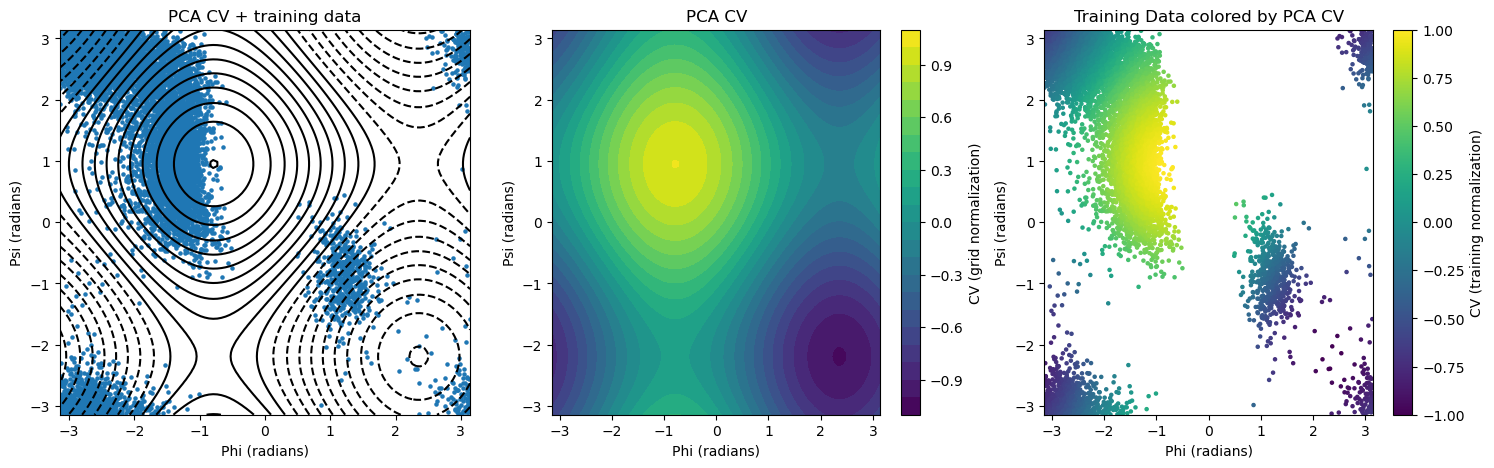

/tmp/ipykernel_104448/152511438.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


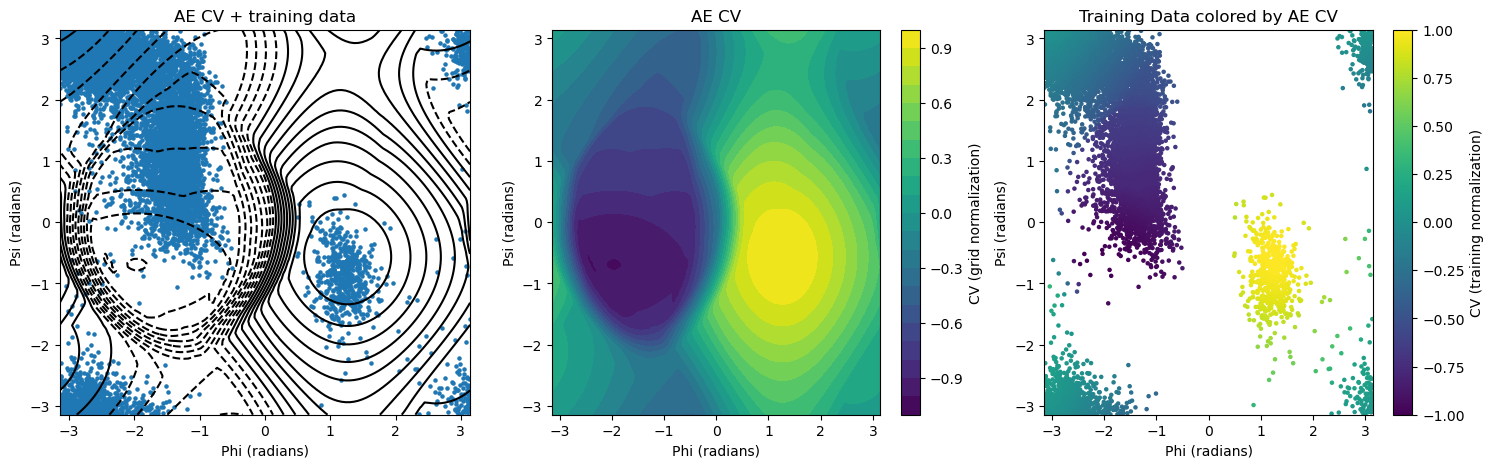

/tmp/ipykernel_104448/152511438.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


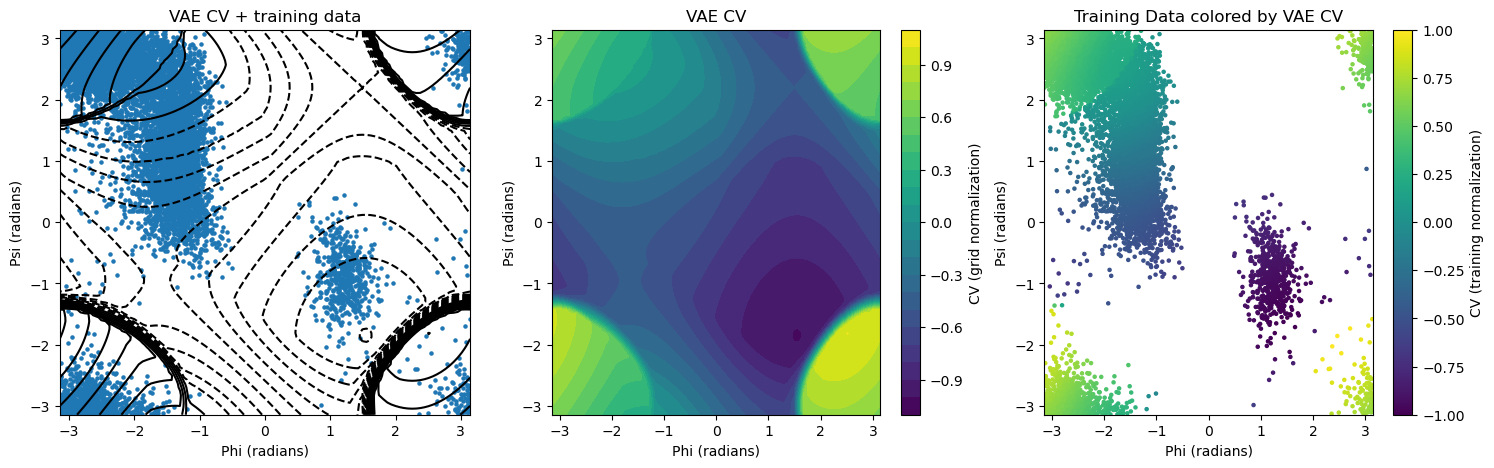

In [5]:
# Create a grid in the space of features
num_bins = 100
phi_values = np.linspace(-math.pi, math.pi, num_bins)
psi_values = np.linspace(-math.pi, math.pi, num_bins)

# Flatten the grid for easier computation
phi_grid, psi_grid = np.meshgrid(phi_values, psi_values)
grid_points = np.vstack([phi_grid.ravel(), psi_grid.ravel()]).T
grid_df = pd.DataFrame(grid_points, columns=['phi', 'psi'])

# Compute features from phi and psi angles, remember the features are computed with ALPHABETA as 0.5*(1+cos(x)) and 0.5*(1-sin(x))
features_grid_df = pd.DataFrame() 
features_grid_df['sin-phi'] = 0.5 * (1 - np.sin(grid_df['phi']))
features_grid_df['cos-phi'] = 0.5 * (1 + np.cos(grid_df['phi']))
features_grid_df['sin-psi'] = 0.5 * (1 - np.sin(grid_df['psi']))
features_grid_df['cos-psi'] = 0.5 * (1 + np.cos(grid_df['psi']))
features_grid_df.columns = [name.replace('phi', '@C_1-@N_2-@CA_2-@C_2') for name in features_grid_df.columns]
features_grid_df.columns = [name.replace('psi', '@N_2-@CA_2-@C_2-@N_3') for name in features_grid_df.columns]

# For the geometric models
for model in ['pca', 'ae', 'vae']:
    model_path = f"{output_folder}/train_colvars/{model}/model.zip"
    projected_training_path = f"{output_folder}/train_colvars/{model}/traj_data/trajectory/projected_trajectory.csv"
    plot_model_results(
        model_path = model_path,
        projected_training_path = projected_training_path,
        x_training_data = training_data['phi'],
        y_training_data = training_data['psi'],
        features_grid_df = features_grid_df,
        x_grid = phi_grid,
        y_grid = psi_grid,
        x_label = 'Phi (radians)',
        y_label = 'Psi (radians)',
        x_lims = (-math.pi, math.pi),
        y_lims = (-math.pi, math.pi),
        num_bins = num_bins,
        num_levels = 20
    )

We can see how the models that explain variance concentrate on describing the change that occurs more frequently during the trajectory, which is the transition between C7eq and C5. This system is simple enough so that the VAE might capture the third metastable state as well if the hyper-parameters are tunned. However, it will always have a tendency to ignore undersampled states that explain little variance. 

Take into account we are using sine and cosines as features, therefore there is some non-linearity in the relationship between the $\phi$, $\psi$ angles and the final CV even when using a PCA model.

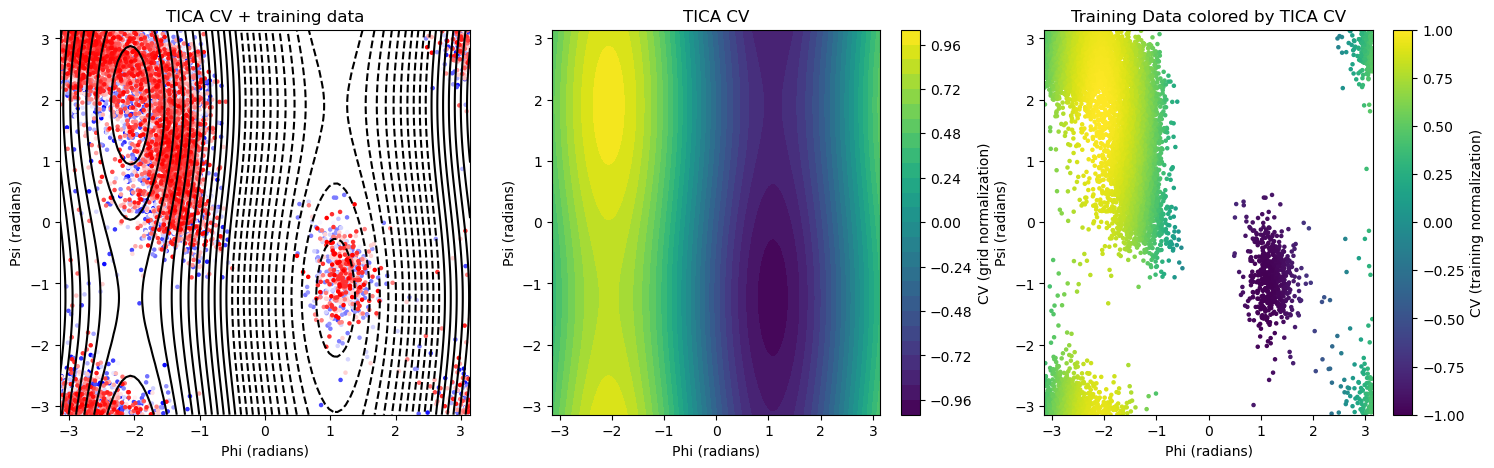

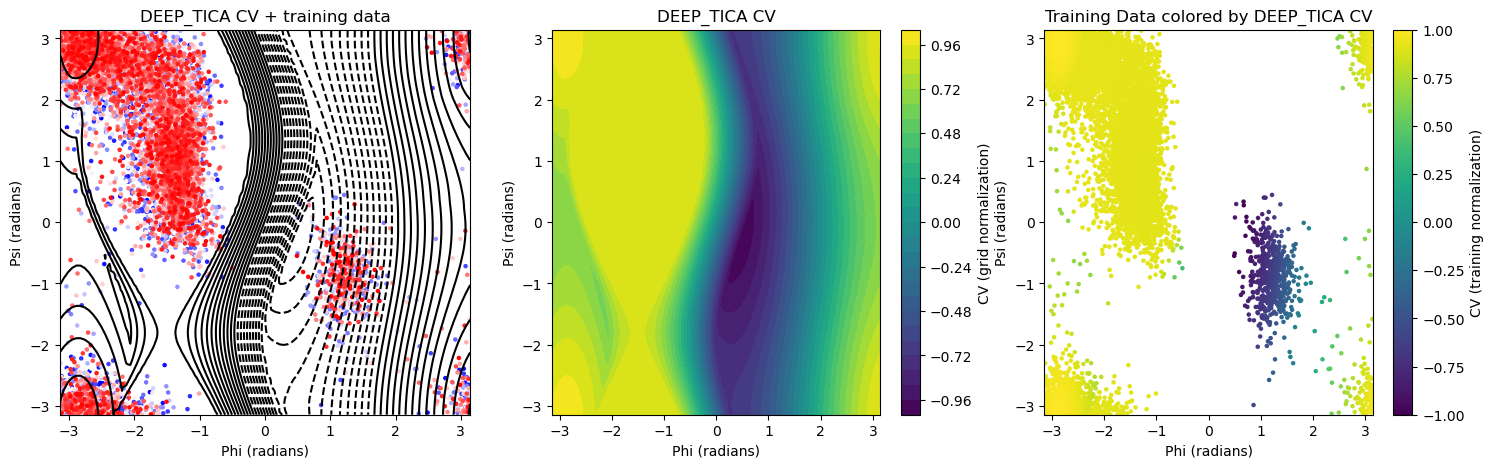

In [6]:
# For the kinetic models
for model in ['tica', 'deep_tica']:
    model_path = f"{output_folder}/train_colvars/{model}/model.zip"
    projected_training_path = f"{output_folder}/train_colvars/{model}/traj_data/trajectory/projected_trajectory.csv"
    plot_model_results(
        model_path = model_path,
        projected_training_path = projected_training_path,
        x_training_data = training_data['phi'],
        y_training_data = training_data['psi'],
        features_grid_df = features_grid_df,
        x_grid = phi_grid,
        y_grid = psi_grid,
        x_label = 'Phi (radians)',
        y_label = 'Psi (radians)',
        x_lims = (-math.pi, math.pi),
        y_lims = (-math.pi, math.pi),
        num_bins = num_bins,
        num_levels = 30,
        training_colors = training_data['time']
    )

Using the data from 400K the slowest mode is not that easy to learn. Increasing lag time, number of epochs, changing the batch size or the architecture doesn't seem to help to learn the slowest mode better. One thing that does help is adding more features (other torsions or distances), see the aladip experiments in the examples folder.

## Discriminative CVs

We can use mlcolvars to compute discriminative CVs for alanine dipeptide.

To do so, we need to define the states we want to discriminate. In this case, we will define two states:

* State A: C7eq and C5 (the two most populated states)
* State B: C7ax (the less populated state)

We can define these states based on the phi and psi angles.

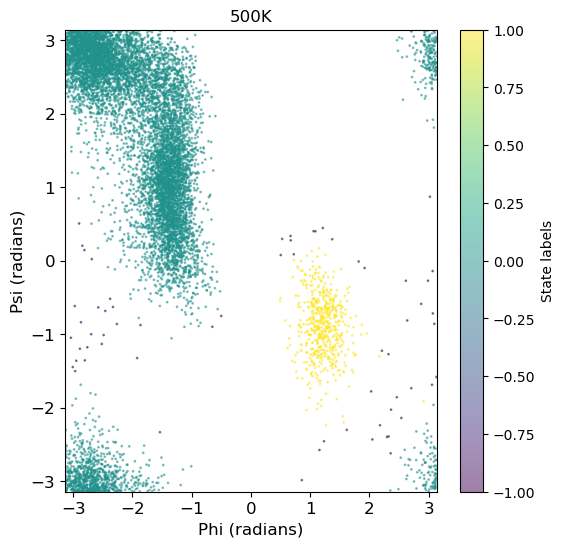

/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /home/pnavarro/.conda/envs/deep_cartograph/lib/p ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True

In [7]:
n_states = 2
num_levels = 30
cv_cmap = 'viridis'

output_folder = f"output_phi_psi_{temperature}K"

feature1 = 'phi'
feature2 = 'psi'
x_lims = (-math.pi, math.pi)
y_lims = (-math.pi, math.pi)
x_label = 'Phi (radians)'
y_label = 'Psi (radians)'

nn_layers = [4,10,10,5]

# Cluster original training data to create state labels
colvars_path = f"{output_folder}/compute_features/trajectory/colvars.dat"
original_training_data = read_colvars(colvars_path)
original_training_data = original_training_data.filter(regex="^(?!.*time)")

# Normalize original training data
normalized_original_training_data = original_training_data.copy()
mean = normalized_original_training_data.mean()
std = normalized_original_training_data.std()
normalized_original_training_data = (normalized_original_training_data - mean) / std

# Cluster original data
settings = {
    "algorithm": "hdbscan",
    "min_cluster_size": 100,
    "min_samples": 200
}
labels, centroids = cluster_data(
    features=normalized_original_training_data.values,
    settings=settings
)
normalized_original_training_data['labels'] = labels
original_training_data['labels'] = labels

# Show clustered training data
plot_scatter(x = training_data[feature1], 
             y = training_data[feature2], 
             color = labels, 
             xlims = x_lims, 
             ylims = y_lims, 
             xlabel = x_label, 
             ylabel = y_label, 
             title = f'{temperature}K', 
             colorlabel = "State labels", 
             font_size=12)

# Remove noise points for LDA training
lda_training_data = normalized_original_training_data[normalized_original_training_data['labels'] != -1].copy()
lda_labels = lda_training_data['labels'].values
lda_training_data = lda_training_data.filter(regex="^(?!.*labels)")

# Compute LDA eigenvalues and eigenvectors
dictionary = {"data": torch.Tensor(lda_training_data.values), "labels": torch.Tensor(lda_labels)}
X = dictionary['data']
lda = LDA(in_features=X.shape[1], n_states=n_states, mode='standard')
eigvals, eigvecs = lda.compute(X,torch.tensor(lda_labels))

# Normalize the grid features with the same mean and std as the training data
normalized_features_grid_df = (features_grid_df - mean) / std

# Project grid and training data onto LDA components
lda_cv_grid = normalized_features_grid_df @ eigvecs[:, 0:1].numpy()
lda_cv_training = lda_training_data @ eigvecs[:, 0:1].numpy()

# Normalize between 0 and 1 for better visualization
lda_cv_grid_min = lda_cv_grid.min().values[0]
lda_cv_grid_max = lda_cv_grid.max().values[0]
lda_cv_grid_normalized = (lda_cv_grid - lda_cv_grid_min) / (lda_cv_grid_max - lda_cv_grid_min)
lda_cv_training_normalized = (lda_cv_training - lda_cv_grid_min) / (lda_cv_grid_max - lda_cv_grid_min)

# Create Deep LDA model
n_components = n_states-1
nn_args = {'activation': 'relu'}
options= {'nn': nn_args}
model = DeepLDA(nn_layers,n_states=n_states, options=options)
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_eigval_1_epoch", mode='max', min_delta=1e-3, patience=50)
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=250, logger=None, enable_checkpointing=False, enable_progress_bar=False)
dataset = DictDataset(dictionary, feature_names=lda_training_data.columns.values)
datamodule = DictModule(dataset, lengths=[0.8,0.2])
trainer.fit( model, datamodule )

# Project grid and training data onto Deep LDA components
with torch.no_grad():
    normalized_features_grid_tensor = torch.tensor(normalized_features_grid_df.values, dtype=torch.float32)
    deep_lda_cv_grid = model(normalized_features_grid_tensor)
    lda_training_tensor = torch.tensor(lda_training_data.values, dtype=torch.float32)
    deep_lda_cv_training = model(lda_training_tensor)

# Convert to DataFrame
deep_lda_cv_grid_array = deep_lda_cv_grid.numpy()
deep_lda_cv_grid = pd.DataFrame(deep_lda_cv_grid_array, columns=['CV'])
deep_lda_cv_training_array = deep_lda_cv_training.numpy()
deep_lda_cv_training = pd.DataFrame(deep_lda_cv_training_array, columns=['CV'])

# Normalize between 0 and 1 for better visualization
deep_lda_cv_grid_min = deep_lda_cv_grid.min().values[0]
deep_lda_cv_grid_max = deep_lda_cv_grid.max().values[0]
deep_lda_cv_grid_normalized = (deep_lda_cv_grid - deep_lda_cv_grid_min) / (deep_lda_cv_grid_max - deep_lda_cv_grid_min)
deep_lda_cv_training_normalized = (deep_lda_cv_training - deep_lda_cv_grid_min) / (deep_lda_cv_grid_max - deep_lda_cv_grid_min)

# Compute phi and psi angles from features data used for training
used_training_data = original_training_data[original_training_data['labels'] != -1]
used_training_data.columns = [name.replace('@C_1-@N_2-@CA_2-@C_2', 'phi') for name in used_training_data.columns]
used_training_data.columns = [name.replace('@N_2-@CA_2-@C_2-@N_3', 'psi') for name in used_training_data.columns]
for feature in ['sin-phi', 'cos-phi', 'sin-psi', 'cos-psi']:
    used_training_data[feature] = (used_training_data[feature] * 2 - 1)
    if feature.startswith('sin'):
        used_training_data[feature] = used_training_data[feature] * -1
used_training_data['phi'] = np.arctan2(used_training_data['sin-phi'], used_training_data['cos-phi'])
used_training_data['psi'] = np.arctan2(used_training_data['sin-psi'], used_training_data['cos-psi'])

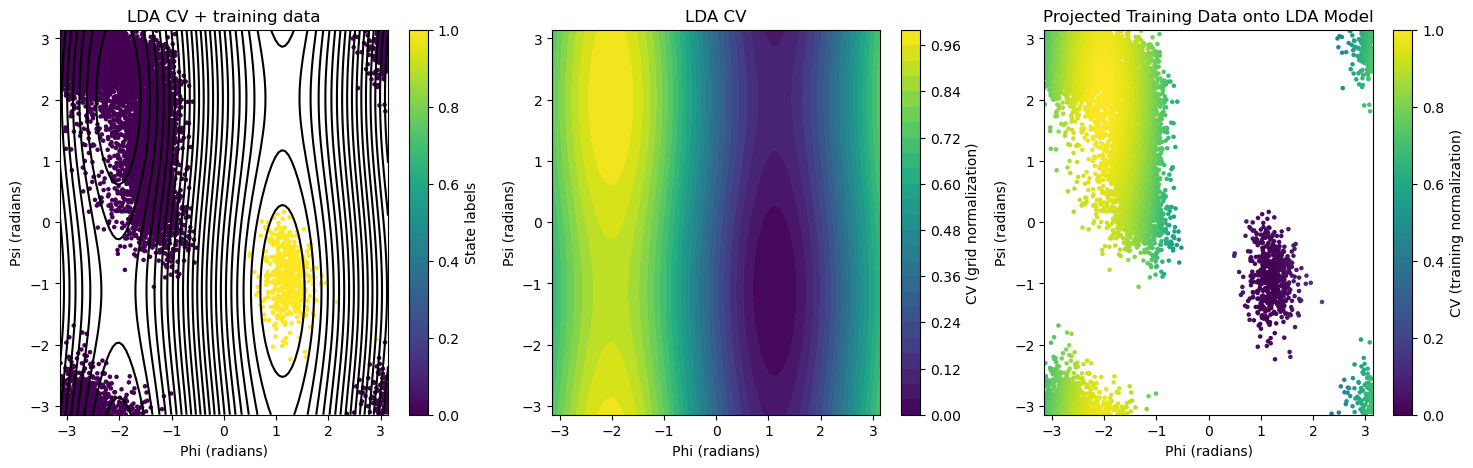

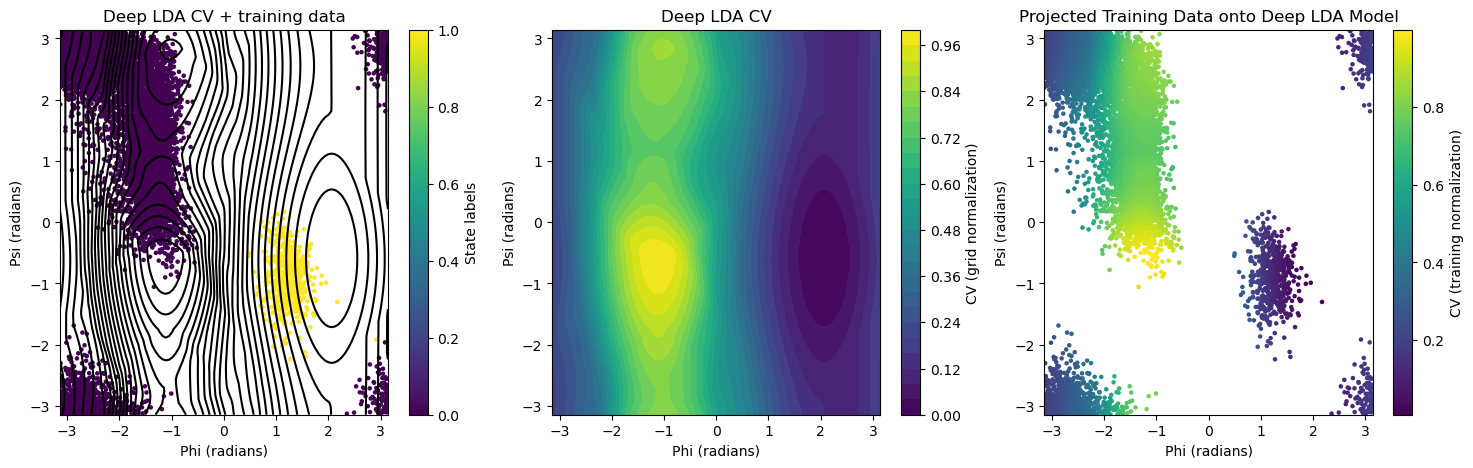

In [8]:
plot_lda_results(
    x_training_data = used_training_data[feature1],
    y_training_data = used_training_data[feature2],
    projected_training_data = lda_cv_training_normalized,
    lda_cv_grid_normalized = lda_cv_grid_normalized,
    x_grid = phi_grid,
    y_grid = psi_grid,
    x_label = x_label,
    y_label = y_label, 
    x_lims = x_lims,
    y_lims = y_lims,
    num_bins = num_bins,
    num_levels = 30,
    training_colors = used_training_data['labels'],
    cv_cmap = 'viridis',
    model_name = 'LDA')
    
# Plots for Deep LDA model
plot_lda_results(
    x_training_data = used_training_data[feature1],
    y_training_data = used_training_data[feature2],
    projected_training_data = deep_lda_cv_training_normalized,
    lda_cv_grid_normalized = deep_lda_cv_grid_normalized,
    x_grid = phi_grid,
    y_grid = psi_grid,
    x_label = x_label,
    y_label = y_label, 
    x_lims = x_lims,
    y_lims = y_lims,
    num_bins = num_bins,
    num_levels = 30,
    training_colors = used_training_data['labels'],
    cv_cmap = 'viridis',
    model_name = 'Deep LDA')

Now we can try to use pairs of distances as input features to remove the non-linearities introduced by the sine and cosine transformations. A configuration file for this purpose is provided in `config_distances.yml` of this same folder.

In [9]:
# Temperature of the aladip simulations
temperature : Literal[300, 400, 500] = 500

# Paths to trajectory and topology files
traj_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/trajectory.xtc"
top_path = f"{data_folder}/alanine_dipeptide/input/topology.pdb"

# Load configuration file
config_path = 'config_distances.yml'
with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)

# Output folder
output_folder = f"output_distances_{temperature}K"

# Run workflow 
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
deep_cartograph(
    trajectory_data = traj_path,
    topology_data = top_path,
    configuration = configuration,
    output_folder = output_folder
)

/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
Provided topology does not contain bonds. Bonds will be guessed using a distance criterion (bond_length < 2.0). Distances between b

KEY:  data




/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element 

KLAAnnealing initialized with type=sigmoid, start_beta=1e-06, max_beta=0.01)


`Trainer.fit` stopped: `max_epochs=200` reached.
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


KEY:  data




/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element 

KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element 

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

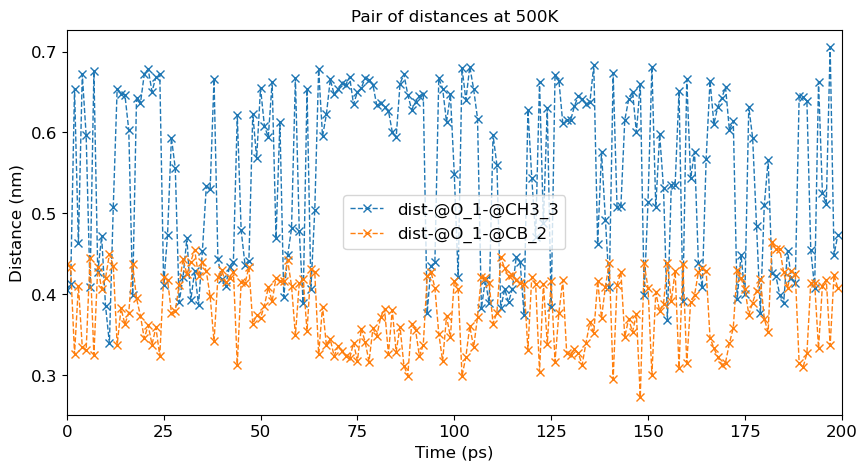

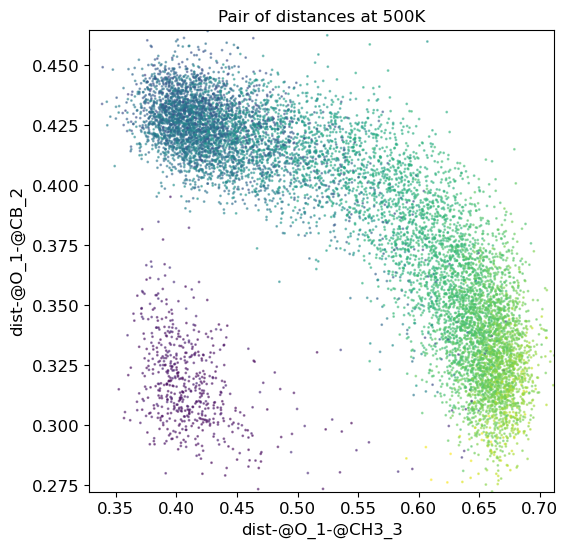

In [23]:
# Distances data
phi_psi_path = f"{data_folder}/alanine_dipeptide/input/{temperature}K/phi_psi.dat"
phi_psi_data = read_colvars(phi_psi_path)
phi_psi_data['time'] = phi_psi_data['time'] * 1000
phi_psi_data = phi_psi_data[phi_psi_data['time'] < max_time]

# Load the training data computed with Deep Cartograph
output_folder = f"output_distances_{temperature}K"
colvars_path = f"{output_folder}/compute_features/trajectory/colvars.dat"
training_data = read_colvars(colvars_path)

# Convert time from ns to ps
training_data['time'] = training_data['time'] * 1000

# Features
feature1 = 'dist-@O_1-@CH3_3'
feature2 = 'dist-@O_1-@CB_2'

x_label = feature1 + ' (nm)'
y_label = feature2 + ' (nm)'

# Sample just the first 200 ps for the plot
training_data_zoom = training_data[training_data['time'] < max_time].loc[:, ['time', feature1, feature2]]

# Save limits
x_lims = (training_data[feature1].min(), training_data[feature1].max())
y_lims = (training_data[feature2].min(), training_data[feature2].max())

# Load previous vae cv - to see states in this new feature space
output_folder = f"output_phi_psi_{temperature}K"
vae_traj_path = f"{output_folder}/train_colvars/vae/traj_data/trajectory/projected_trajectory.csv"
vae_value = pd.read_csv(vae_traj_path)
vae_array = vae_value[vae_value.columns[0]].values

# Plot the time series
plot_timeseries(time_array = training_data_zoom['time'], 
                feature1_array = training_data_zoom[feature1], 
                feature2_array = training_data_zoom[feature2], 
                feature1_legend = feature1, 
                feature2_legend = feature2, 
                features_label = 'Distance (nm)',
                max_time = max_time, 
                feature_limits = None,
                title = f'Pair of distances at {temperature}K', 
                font_size=font_size)

# Plot a phi vs psi scatter plot of the whole trajectory
plot_scatter(x = training_data[feature1], 
             y = training_data[feature2], 
             color = vae_array, 
             xlims = x_lims, 
             ylims = y_lims, 
             xlabel = feature1, 
             ylabel = feature2, 
             title = f'Pair of distances at {temperature}K', 
             colorlabel = None, 
             font_size=12)

/tmp/ipykernel_44964/152511438.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


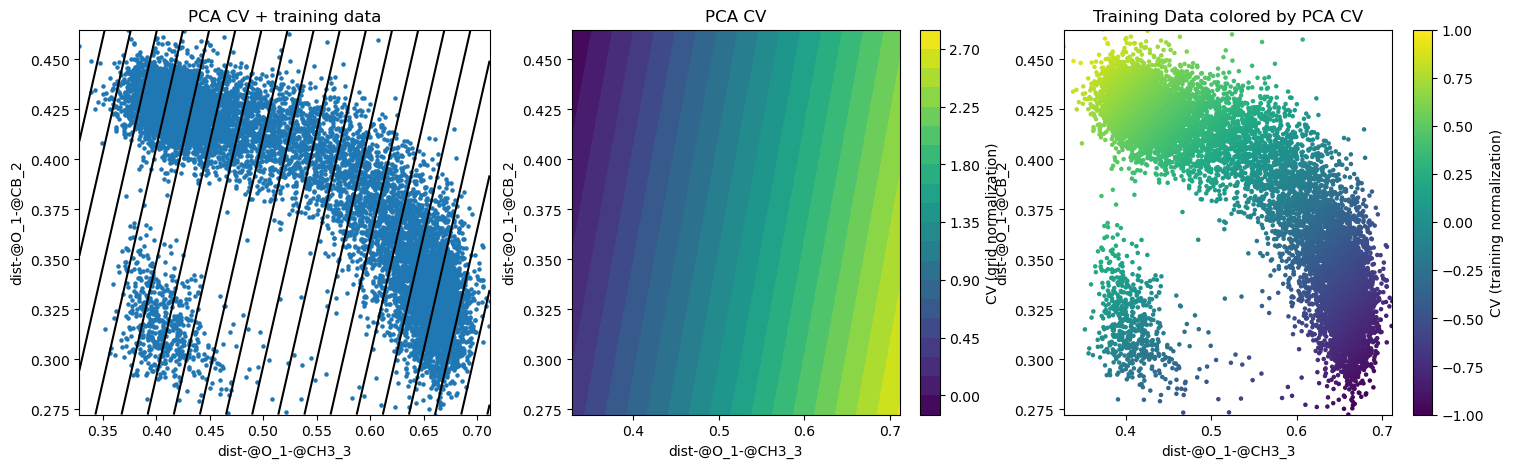

/tmp/ipykernel_44964/152511438.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


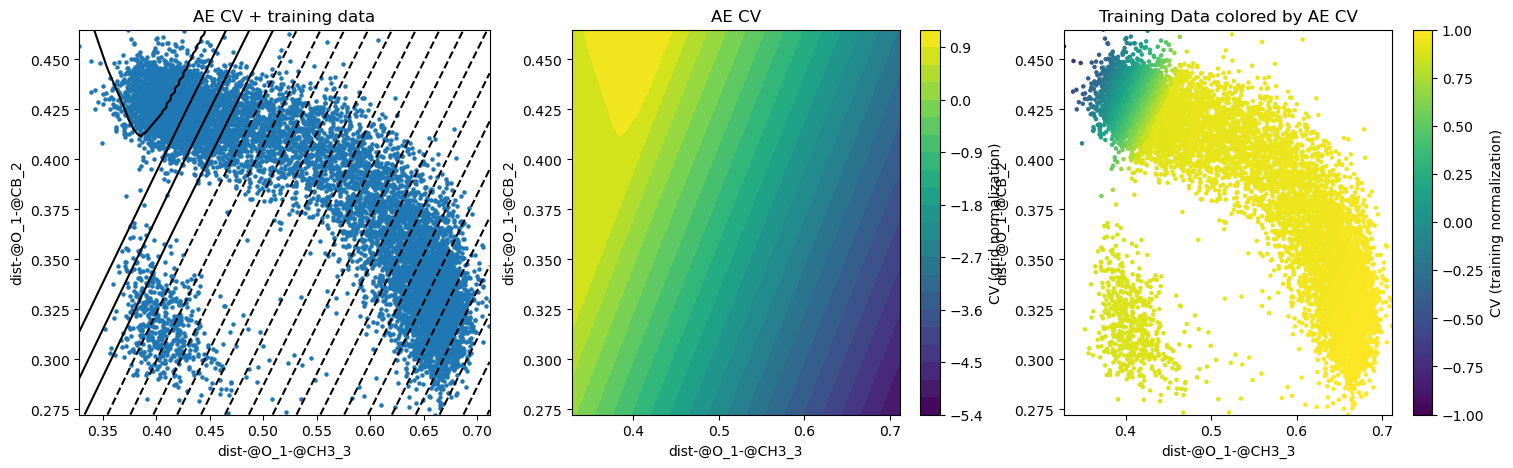

/tmp/ipykernel_44964/152511438.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


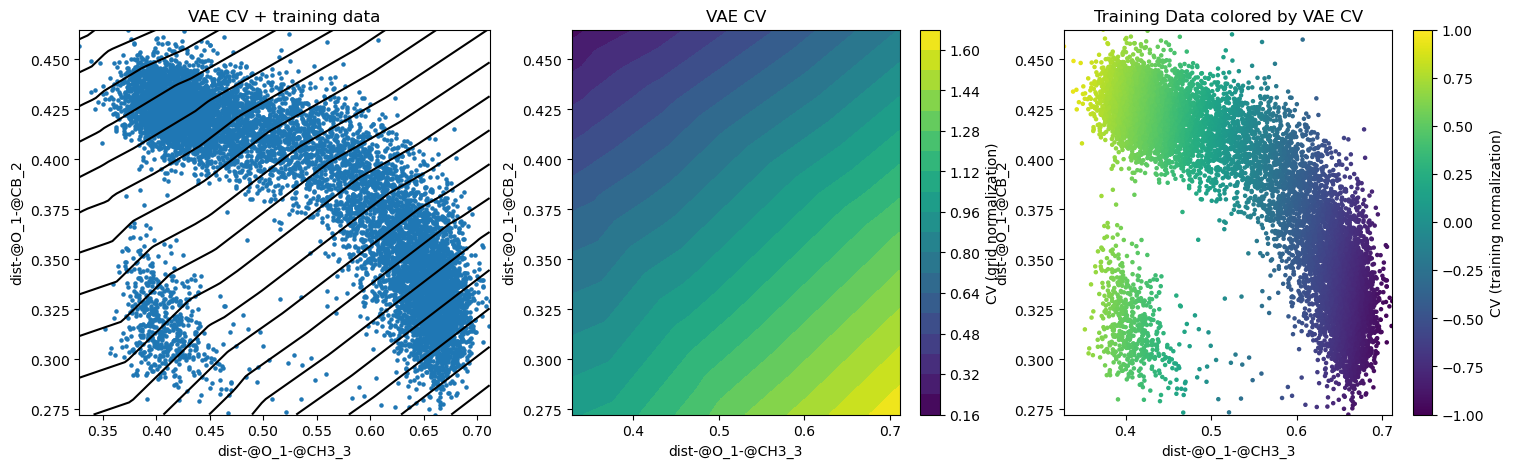

In [24]:
# Create a grid in the space of features
num_bins = 100
x_values = np.linspace(x_lims[0], x_lims[1], num_bins)
y_values = np.linspace(y_lims[0], y_lims[1], num_bins)

# Flatten the grid for easier computation
x_grid, y_grid = np.meshgrid(x_values, y_values)
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
grid_df = pd.DataFrame(grid_points, columns=[feature1, feature2])

# For the geometric models
output_folder = f"output_distances_{temperature}K"
for model in ['pca', 'ae', 'vae']:
    model_path = f"{output_folder}/train_colvars/{model}/model.zip"
    projected_training_path = f"{output_folder}/train_colvars/{model}/traj_data/trajectory/projected_trajectory.csv"
    plot_model_results(
        model_path = model_path,
        projected_training_path = projected_training_path,
        x_training_data = training_data[feature1],
        y_training_data = training_data[feature2],
        features_grid_df = grid_df,
        x_grid = x_grid,
        y_grid = y_grid,
        x_label = feature1,
        y_label = feature2,
        x_lims = x_lims,
        y_lims = y_lims,
        num_bins = num_bins,
        num_levels = 20
    )

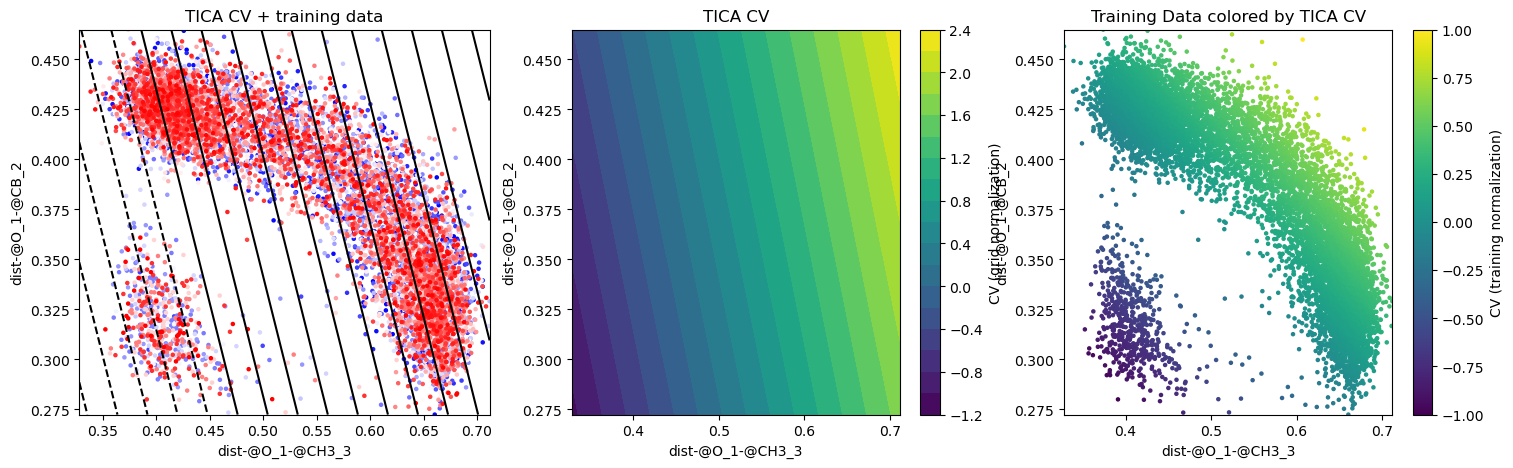

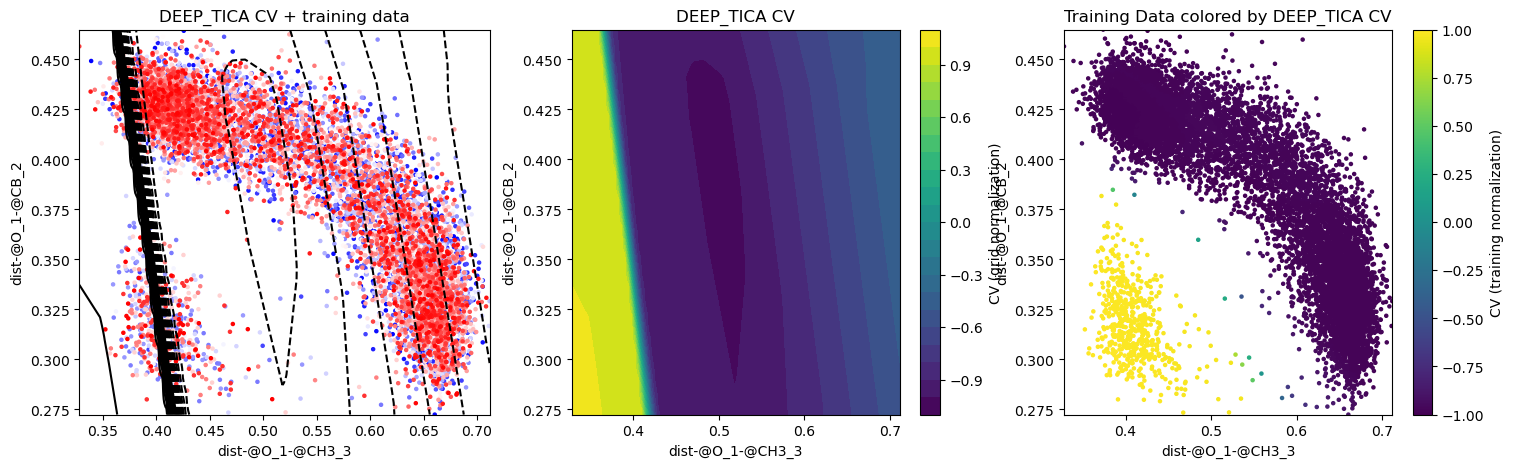

In [25]:
# For the kinetic models
output_folder = f"output_distances_{temperature}K"
for model in ['tica', 'deep_tica']:
    model_path = f"{output_folder}/train_colvars/{model}/model.zip"
    projected_training_path = f"{output_folder}/train_colvars/{model}/traj_data/trajectory/projected_trajectory.csv"
    plot_model_results(
      model_path = model_path,
        projected_training_path = projected_training_path,
        x_training_data = training_data[feature1],
        y_training_data = training_data[feature2],
        features_grid_df = grid_df,
        x_grid = x_grid,
        y_grid = y_grid,
        x_label = feature1,
        y_label = feature2,
        x_lims = x_lims,
        y_lims = y_lims,
        num_bins = num_bins,
        num_levels = 20,
        training_colors = training_data['time']
    )

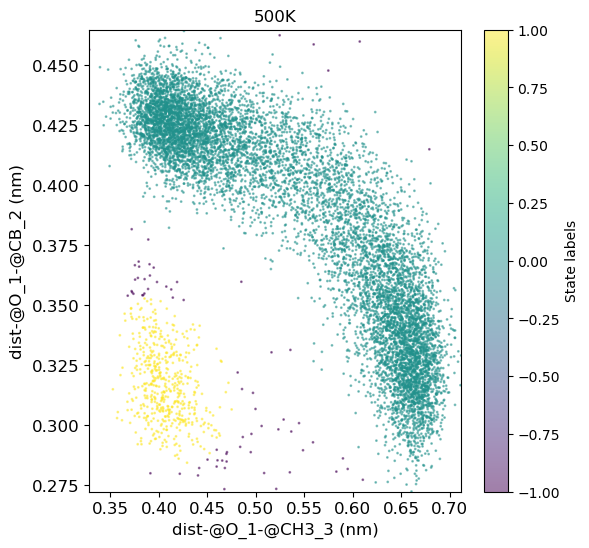

/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /home/pnavarro/.conda/envs/deep_cartograph/lib/p ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------------------
0 | loss_fn | ReduceEigenvaluesLoss | 0      | train | ?        | ?        
1 | norm_in | Normalization         | 0      | train | [1, 2]   | [1, 2]   
2 | nn      | FeedForward           | 195    | train | [1, 2]   | [1, 5]   
3 | lda     | LDA                   | 0      | train | [1, 5]   | [1, 1]   
------------------------------------------------------------------

In [28]:
n_states = 2
num_levels = 30
cv_cmap = 'viridis'

output_folder = f"output_distances_{temperature}K"

nn_layers = [2,10,10,5]

# Cluster original training data to create state labels
colvars_path = f"{output_folder}/compute_features/trajectory/colvars.dat"
original_training_data = read_colvars(colvars_path)
original_training_data = original_training_data.filter(regex="^(?!.*time)")

# Normalize original training data
normalized_original_training_data = original_training_data.copy()
mean = normalized_original_training_data.mean()
std = normalized_original_training_data.std()
normalized_original_training_data = (normalized_original_training_data - mean) / std

# Cluster original data
settings = {
    "algorithm": "hdbscan",
    "min_cluster_size": 100,
    "min_samples": 200
}
labels, centroids = cluster_data(
    features=normalized_original_training_data.values,
    settings=settings
)
normalized_original_training_data['labels'] = labels
original_training_data['labels'] = labels

# Show clustered training data
plot_scatter(x = training_data[feature1], 
             y = training_data[feature2], 
             color = labels, 
             xlims = x_lims, 
             ylims = y_lims, 
             xlabel = x_label, 
             ylabel = y_label, 
             title = f'{temperature}K', 
             colorlabel = "State labels", 
             font_size=12)

# Remove noise points for LDA training
lda_training_data = normalized_original_training_data[normalized_original_training_data['labels'] != -1].copy()
lda_labels = lda_training_data['labels'].values
lda_training_data = lda_training_data.filter(regex="^(?!.*labels)")

# Compute LDA eigenvalues and eigenvectors
dictionary = {"data": torch.Tensor(lda_training_data.values), "labels": torch.Tensor(lda_labels)}
X = dictionary['data']
lda = LDA(in_features=X.shape[1], n_states=n_states, mode='standard')
eigvals, eigvecs = lda.compute(X,torch.tensor(lda_labels))

# Normalize the grid features with the same mean and std as the training data
normalized_features_grid_df = (grid_df - mean) / std

# Project grid and training data onto LDA components
lda_cv_grid = normalized_features_grid_df @ eigvecs[:, 0:1].numpy()
lda_cv_training = lda_training_data @ eigvecs[:, 0:1].numpy()

# Normalize between 0 and 1 for better visualization
lda_cv_grid_min = lda_cv_grid.min().values[0]
lda_cv_grid_max = lda_cv_grid.max().values[0]
lda_cv_grid_normalized = (lda_cv_grid - lda_cv_grid_min) / (lda_cv_grid_max - lda_cv_grid_min)
lda_cv_training_normalized = (lda_cv_training - lda_cv_grid_min) / (lda_cv_grid_max - lda_cv_grid_min)

# Create Deep LDA model
n_components = n_states-1
nn_args = {'activation': 'relu'}
options= {'nn': nn_args}
model = DeepLDA(nn_layers,n_states=n_states, options=options)
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_eigval_1_epoch", mode='max', min_delta=1e-3, patience=50)
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=250, logger=None, enable_checkpointing=False, enable_progress_bar=False)
dataset = DictDataset(dictionary, feature_names=lda_training_data.columns.values)
datamodule = DictModule(dataset, lengths=[0.8,0.2])
trainer.fit( model, datamodule )

# Project grid and training data onto Deep LDA components
with torch.no_grad():
    normalized_features_grid_tensor = torch.tensor(normalized_features_grid_df.values, dtype=torch.float32)
    deep_lda_cv_grid = model(normalized_features_grid_tensor)
    lda_training_tensor = torch.tensor(lda_training_data.values, dtype=torch.float32)
    deep_lda_cv_training = model(lda_training_tensor)

# Convert to DataFrame
deep_lda_cv_grid_array = deep_lda_cv_grid.numpy()
deep_lda_cv_grid = pd.DataFrame(deep_lda_cv_grid_array, columns=['CV'])
deep_lda_cv_training_array = deep_lda_cv_training.numpy()
deep_lda_cv_training = pd.DataFrame(deep_lda_cv_training_array, columns=['CV'])

# Normalize between 0 and 1 for better visualization
deep_lda_cv_grid_min = deep_lda_cv_grid.min().values[0]
deep_lda_cv_grid_max = deep_lda_cv_grid.max().values[0]
deep_lda_cv_grid_normalized = (deep_lda_cv_grid - deep_lda_cv_grid_min) / (deep_lda_cv_grid_max - deep_lda_cv_grid_min)
deep_lda_cv_training_normalized = (deep_lda_cv_training - deep_lda_cv_grid_min) / (deep_lda_cv_grid_max - deep_lda_cv_grid_min)

# Data actually used during training (without noise points)
used_training_data = original_training_data[original_training_data['labels'] != -1]

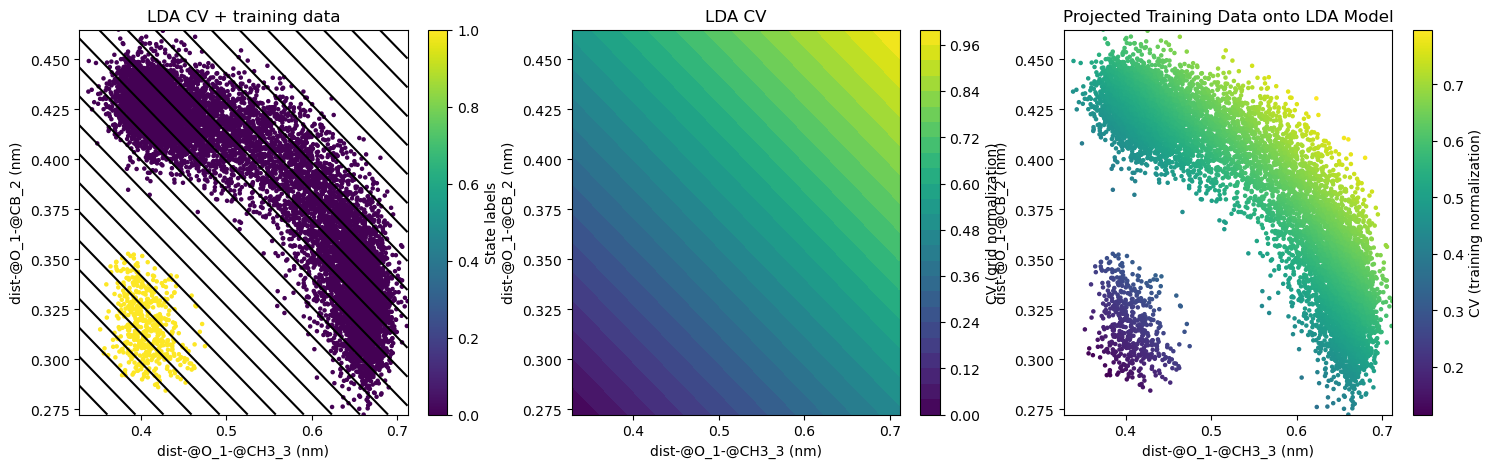

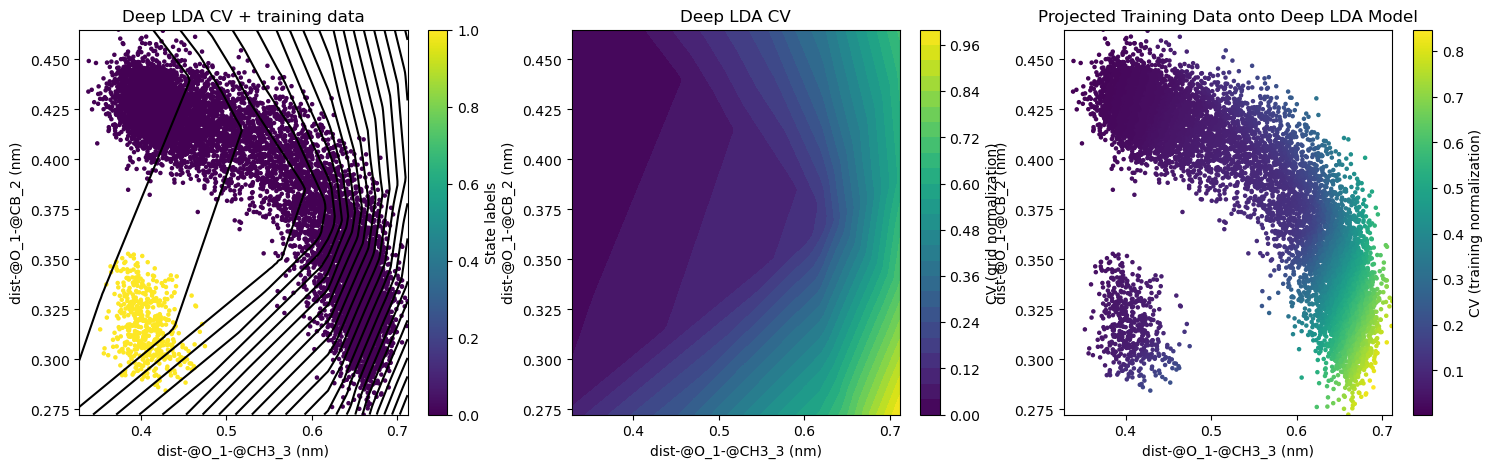

In [29]:
plot_lda_results(
    x_training_data = used_training_data[feature1],
    y_training_data = used_training_data[feature2],
    projected_training_data = lda_cv_training_normalized,
    lda_cv_grid_normalized = lda_cv_grid_normalized,
    x_grid = x_grid,
    y_grid = y_grid,
    x_label = x_label,
    y_label = y_label, 
    x_lims = x_lims,
    y_lims = y_lims,
    num_bins = num_bins,
    num_levels = 30,
    training_colors = used_training_data['labels'],
    cv_cmap = 'viridis',
    model_name = 'LDA')
    
# Plots for Deep LDA model
plot_lda_results(
    x_training_data = used_training_data[feature1],
    y_training_data = used_training_data[feature2],
    projected_training_data = deep_lda_cv_training_normalized,
    lda_cv_grid_normalized = deep_lda_cv_grid_normalized,
    x_grid = x_grid,
    y_grid = y_grid,
    x_label = x_label,
    y_label = y_label, 
    x_lims = x_lims,
    y_lims = y_lims,
    num_bins = num_bins,
    num_levels = 30,
    training_colors = used_training_data['labels'],
    cv_cmap = 'viridis',
    model_name = 'Deep LDA')

## System 2: Muller-Brown Potential

In the previous example, we used sinusoidal features from two dihedrals. This already introduces some non-linearity in the relationship between the features and the CVs, even when using linear models like PCA or LDA. Which makes the interpretation of the results less straightforward. Here we will use a simpler 2D toy model: the Muller-Brown potential.

In [ ]:
from deep_cartograph.tools.train_colvars import train_colvars
import shutil

# Get the path to the data
data_folder = resources.files(data)
colvars_name = "px_py"
colvars_path = f"{data_folder}/muller_brown/{colvars_name}.dat"

# Read data
training_data = read_colvars(colvars_path)

# Read configuration file
config_file = 'config_muller_brown.yml'
with open(config_file, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)

output_folder = "output_muller_brown"

# Clean output folder
shutil.rmtree(output_folder, ignore_errors=True)

# Train models
train_colvars(
    configuration = configuration,
    train_colvars_paths = colvars_path,
    output_folder = output_folder
)

Topology not provided. Skipping PLUMED files creation.
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /home/pnavarro/.conda/envs/deep_cartograph/lib/p ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | MSELoss       | 0      | train | ?        | ?        
1 | norm_in | Normalization | 0      | train | [1, 2]   | [1, 2]   
2 | encoder | FeedForward   | 577    | train | [1, 2]   | [1, 1]   
3 | decoder | FeedForward   | 578    | train | ?        | ?        
-----------------------------------------------------------

KEY:  data




Topology not provided. Skipping PLUMED files creation.
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /home/pnavarro/.conda/envs/deep_cartograph/lib/p ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------------------
0 | loss_fn    | ELBOGaussiansLoss | 0      | train | ?        | ?        
1 | norm_in    | Normalization     | 0      | train | [1, 2]   | [1, 2]   
2 | encoder    | FeedForward       | 574    | train | [1, 2]   | [1, 2]   
3 | mean_nn    | Linear            | 3      | train | [1, 2]   | [1, 1]   
4 | log_var_nn | 

KLAAnnealing initialized with type=sigmoid, start_beta=1e-06, max_beta=0.01)


`Trainer.fit` stopped: `max_epochs=200` reached.


KEY:  data




Topology not provided. Skipping PLUMED files creation.
/home/pnavarro/repos/mlcolvar/mlcolvar/utils/timelagged.py:140: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn(
Topology not provided. Skipping PLUMED files creation.
/home/pnavarro/repos/mlcolvar/mlcolvar/utils/timelagged.py:140: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn(
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /home/pnavarro/.conda/envs/deep_cartograph/lib/p ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type

KEY:  data


KEY:  data_lag


KEY:  weights


KEY:  weights_lag




Topology not provided. Skipping PLUMED files creation.


{'pca': {'output_folder': 'output_muller_brown/pca',
  'model_path': 'output_muller_brown/pca/model.zip',
  'traj_paths': ['output_muller_brown/pca/traj_data/px_py/projected_trajectory.csv']},
 'ae': {'output_folder': 'output_muller_brown/ae',
  'model_path': 'output_muller_brown/ae/model.zip',
  'traj_paths': ['output_muller_brown/ae/traj_data/px_py/projected_trajectory.csv']},
 'vae': {'output_folder': 'output_muller_brown/vae',
  'model_path': 'output_muller_brown/vae/model.zip',
  'traj_paths': ['output_muller_brown/vae/traj_data/px_py/projected_trajectory.csv']},
 'tica': {'output_folder': 'output_muller_brown/tica',
  'model_path': 'output_muller_brown/tica/model.zip',
  'traj_paths': ['output_muller_brown/tica/traj_data/px_py/projected_trajectory.csv']},
 'deep_tica': {'output_folder': 'output_muller_brown/deep_tica',
  'model_path': 'output_muller_brown/deep_tica/model.zip',
  'traj_paths': ['output_muller_brown/deep_tica/traj_data/px_py/projected_trajectory.csv']}}

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

Reference topology file not found in the model.
/tmp/ipykernel_39001/3325618717.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


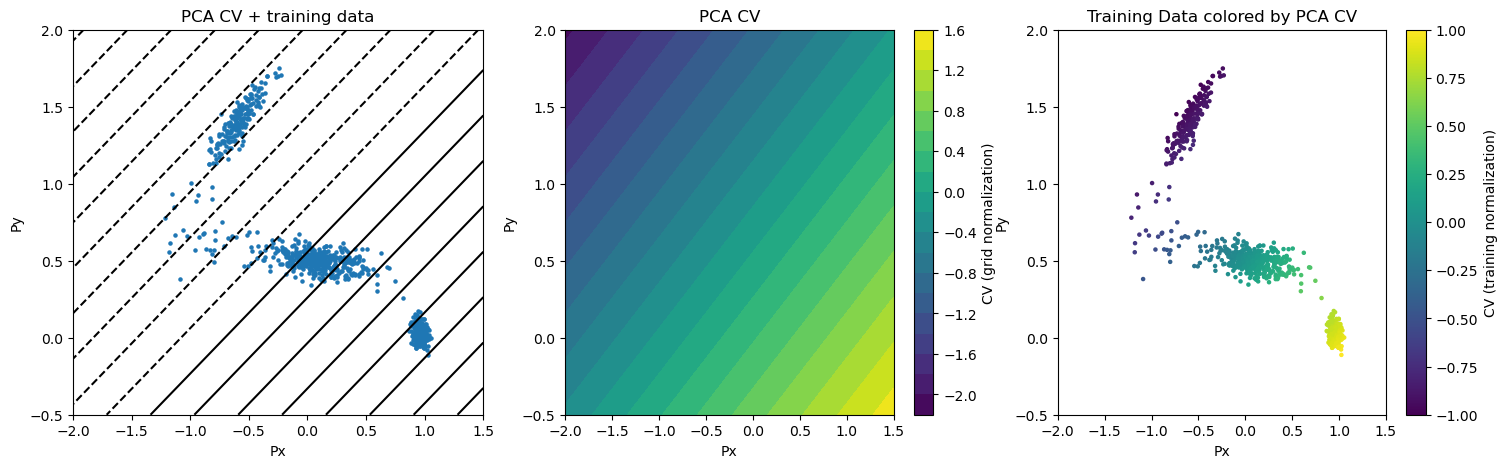

Reference topology file not found in the model.
/tmp/ipykernel_39001/3325618717.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


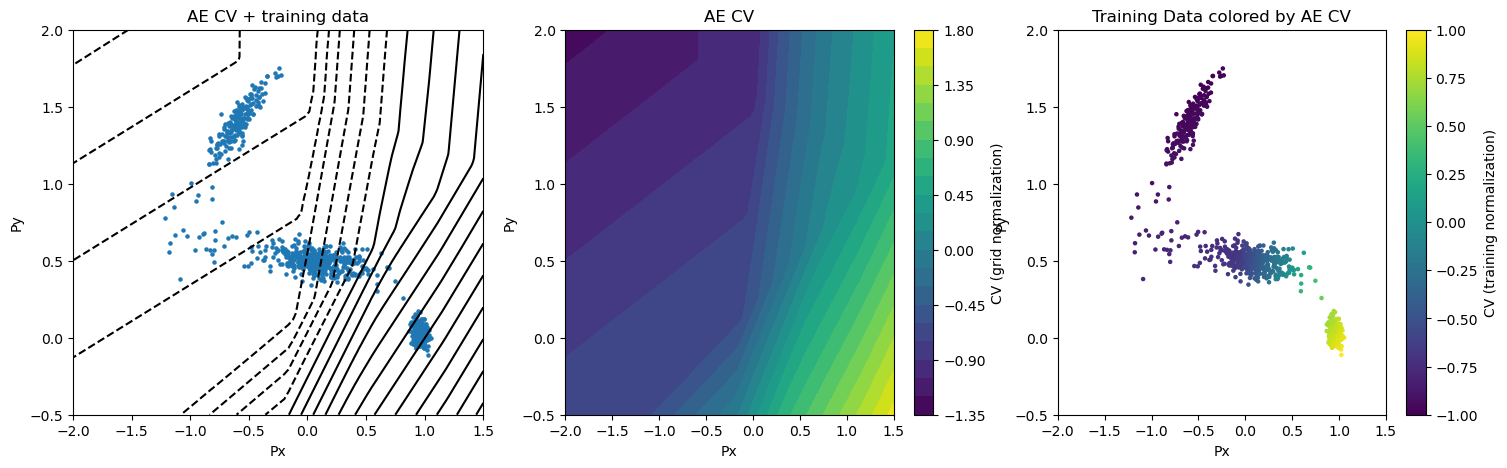

Reference topology file not found in the model.
/tmp/ipykernel_39001/3325618717.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


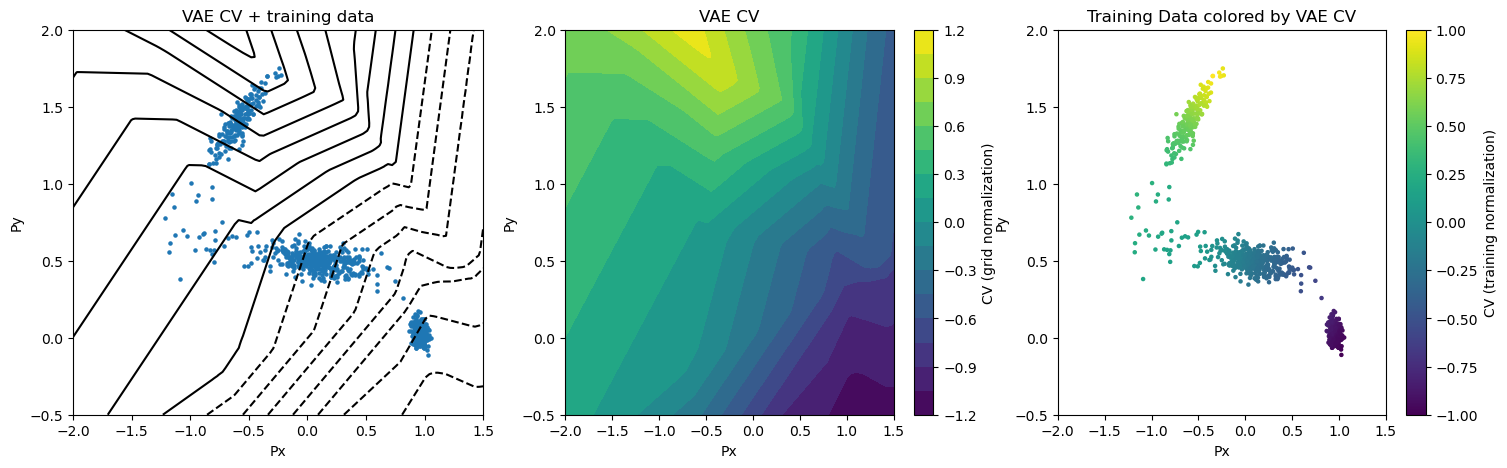

Reference topology file not found in the model.
/tmp/ipykernel_39001/3325618717.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


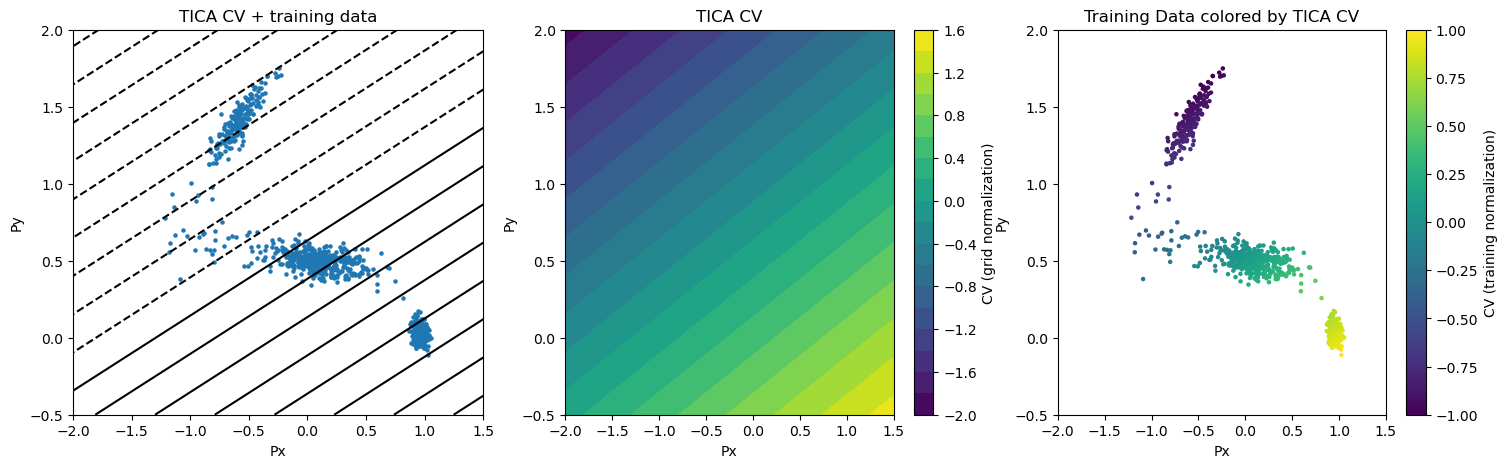

Reference topology file not found in the model.
/tmp/ipykernel_39001/3325618717.py:187: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x = x_training_data,


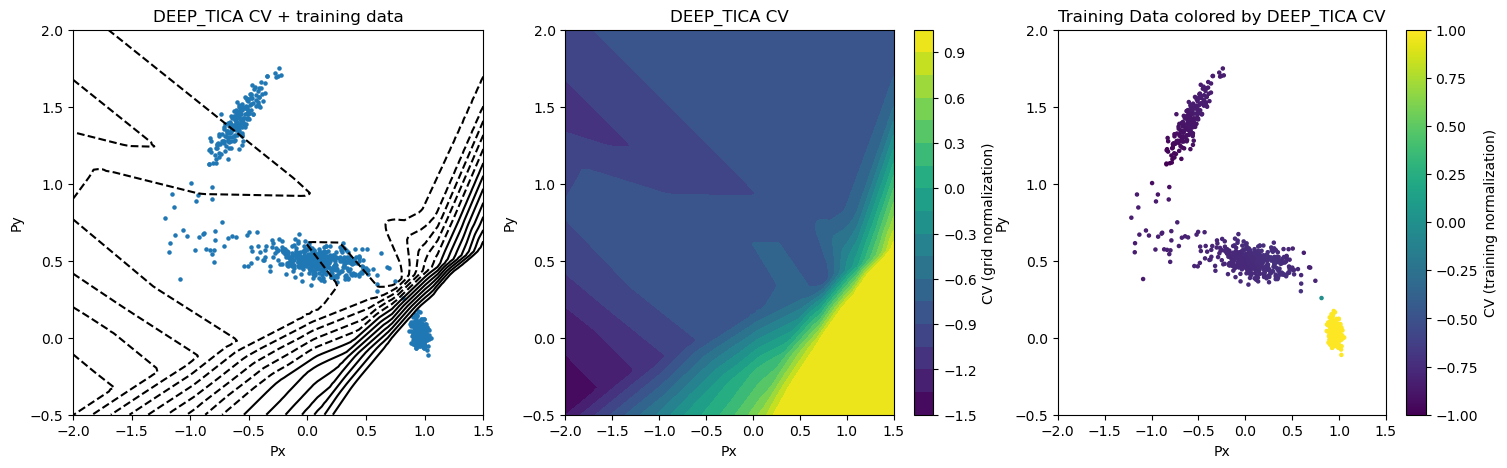

In [ ]:
# Create a grid in the space of features
num_bins = 100
px_values = np.linspace(-2.0, 1.5, num_bins)
py_values = np.linspace(-0.5, 2.0, num_bins)

# Flatten the grid for easier computation
px_grid, py_grid = np.meshgrid(px_values, py_values)
grid_points = np.vstack([px_grid.ravel(), py_grid.ravel()]).T
grid_df = pd.DataFrame(grid_points, columns=['px', 'py'])

# For the geometric and kinetic models
for model in ['pca', 'ae', 'vae', 'tica', 'deep_tica']:
    model_path = f"{output_folder}/{model}/model.zip"
    projected_training_path = f"{output_folder}/{model}/traj_data/{colvars_name}/projected_trajectory.csv"
    plot_model_results(
        model_path = model_path,
        projected_training_path = projected_training_path,
        x_training_data = training_data['p.x'],
        y_training_data = training_data['p.y'],
        features_grid_df = grid_df,
        x_grid = px_grid,
        y_grid = py_grid,
        x_label = 'Px',
        y_label = 'Py',
        x_lims = (-2, 1.5),
        y_lims = (-0.5, 2.0),
        num_bins = num_bins,
        num_levels = 20
    )